# Import modules and set float format

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as sk
import scipy
from scipy.stats import mannwhitneyu

pd.set_option('float_format', '{:f}'.format)
sns.set_style('white')

# Import data
* Rename chrom_name for LG2 to 'LG2,Neo-X' so Neo-X and Chr2 orthologs get treated the same way in all species.

In [2]:
raw = pd.read_csv('/Users/jpdemuth/5Species/Data/combined_data_5_species.csv')
raw.loc[raw['chrom_num'] == 'LG2','chrom_name'] = 'LG2,Neo-X'
data=raw[['og', 'seq_id', 'sample', 'gender', 'species', 'chrom_num', 'chrom_name', 'TMM']].rename(columns={'og':'OrthoID','TMM':'Current_TMM'})
data.groupby('species').describe().transpose()

species                 G_corn       T_brev       T_cast       T_conf  \
Current_TMM count 66688.000000 71908.000000 61536.000000 67916.000000   
            mean     28.359864    41.578613    48.618394    34.455476   
            std     240.010558   598.835418   316.412056   312.315008   
            min       0.000000     0.000000     0.000000     0.000000   
            25%       0.244667     0.241882     0.602677     0.236868   
            50%       3.207240     2.504949     8.846313     3.759857   
            75%      16.271572    16.780583    29.159560    19.267721   
            max   20416.027535 57926.771352 28917.386233 31306.320044   

species                 T_frem  
Current_TMM count 74156.000000  
            mean     36.601874  
            std     307.786369  
            min       0.000000  
            25%       0.187067  
            50%       2.969612  
            75%      19.301871  
            max   40378.115646

# Filter - single copy orthologs

In [3]:
with open('/Users/jpdemuth/5Species/sc_og_list.txt', 'r') as sc_ortho_file:
    sc_ortholog_list = list(sc_ortho_file.read().split('\n'))

sc_ortho_df = data[data['OrthoID'].isin(sc_ortholog_list)].reset_index(drop=True)
sc_ortho_df.groupby('species').describe().transpose()

species                 G_corn       T_brev       T_cast       T_conf  \
Current_TMM count 16288.000000 16288.000000 16288.000000 16288.000000   
            mean     14.944099    44.928195    33.883464    18.415882   
            std      18.305940   712.002841   267.946805    30.746964   
            min       0.000000     0.000000     0.000000     0.000000   
            25%       3.555515     3.569901     6.491956     3.882116   
            50%       9.740296    10.309348    15.347818    11.377446   
            75%      19.365459    22.038693    29.508853    22.785584   
            max     292.152809 43195.014542 28917.386233  1591.126172   

species                 T_frem  
Current_TMM count 16288.000000  
            mean     37.536945  
            std     286.461349  
            min       0.000000  
            25%       5.122896  
            50%      12.796177  
            75%      25.357918  
            max   18103.850833

# Histogram: Unscaled TMM values

<Figure size 288x144 with 0 Axes>

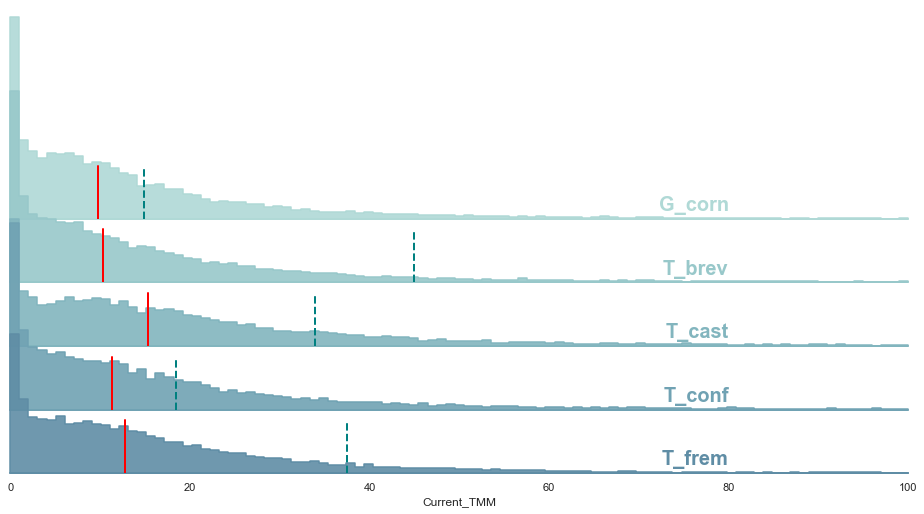

In [4]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.figure(figsize=(4,2))

# Initialize the FacetGrid object (controls for faded color and size of subplots)
pal = sns.cubehelix_palette(10, rot=-.25, light=.8)
g = sns.FacetGrid(sc_ortho_df, row="species", hue="species", aspect=9, height=1.5, palette=pal)

# Draw the histograms (controls for style of bars) 
g.map(sns.histplot, "Current_TMM", clip_on=False, fill=True, alpha=.9, lw=1.5, bins=np.linspace(0,100,100), element="step");

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False);

# Label each subplot (control position on axes(h,v))
def label(x, color, label):
    ax = plt.gca()
    ax.text(.8, .11, label, fontweight="bold", fontsize="20", color=color, ha="right", va="top", transform=ax.transAxes)


g.map(label, "Current_TMM")

# Set the amount of subplot overlap
g.figure.subplots_adjust(hspace=-.7);

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(xlim = (0,100))
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Draw median line on each distribution (note: ymax + hspace above = 1 to draw between axes)
median_position = sc_ortho_df.groupby(['species'])['Current_TMM'].median()
for ax, median_line in zip(g.axes.flat, median_position):
    ax.axvline(x=median_line, ymax = .25, color='red', linestyle='-', lw = 2);
    
mean_position = sc_ortho_df.groupby(['species'])['Current_TMM'].mean()
for ax, mean_line in zip(g.axes.flat, mean_position):
    ax.axvline(x=mean_line, ymax = .25, color='teal', linestyle='--', lw = 2);

# Scale Data - make medians equivalent across species
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

In [5]:
cols=['Current_TMM']
def CreateScaled(x):
    x[['robust_TMM']] = sk.RobustScaler().fit_transform(x[cols])
    return x

scaled_df = sc_ortho_df.groupby(['species']).apply(CreateScaled)

### add abs(minimum) + 0.01 to avoid divide by 0 and log of 0 problems downstream###
scaled_df['positive_robust_TMM'] = scaled_df['robust_TMM'] + abs(min(scaled_df['robust_TMM'])) + 0.01
scaled_df.drop(['robust_TMM'], inplace=True, axis=1)

In [6]:
### OPTIONAL WRITE scaled_df with replicates checkpoint
scaled_df.to_csv('scaled_df.csv', index=False)
scaled_df.groupby('species').describe().transpose()

species                         G_corn       T_brev       T_cast       T_conf  \
Current_TMM         count 16288.000000 16288.000000 16288.000000 16288.000000   
                    mean     14.944099    44.928195    33.883464    18.415882   
                    std      18.305940   712.002841   267.946805    30.746964   
                    min       0.000000     0.000000     0.000000     0.000000   
                    25%       3.555515     3.569901     6.491956     3.882116   
                    50%       9.740296    10.309348    15.347818    11.377446   
                    75%      19.365459    22.038693    29.508853    22.785584   
                    max     292.152809 43195.014542 28917.386233  1591.126172   
positive_robust_TMM count 16288.000000 16288.000000 16288.000000 16288.000000   
                    mean      1.005954     2.551258     1.482113     1.049142   
                    std       1.157875    38.551674    11.641309     1.626525   
                    min       0.060720     0.118603     0.010000     0.074936   
                    25%       0.285611     0.311897     0.292052     0.280301   
                    50%       0.676807     0.676807     0.676807     0.676807   
                    75%       1.285611     1.311897     1.292052     1.280301   
                    max      18.539774  2338.929680  1256.364696    84.246062   

species                         T_frem  
Current_TMM         count 16288.000000  
                    mean     37.536945  
                    std     286.461349  
                    min       0.000000  
                    25%       5.122896  
                    50%      12.796177  
                    75%      25.357918  
                    max   18103.850833  
positive_robust_TMM count 16288.000000  
                    mean      1.899477  
                    std      14.156710  
                    min       0.044429  
                    25%       0.297599  
                    50%       0.676807  
                    75%       1.297599  
                    max     894.723480

# Histogram: Scaled TMM

<Figure size 288x144 with 0 Axes>

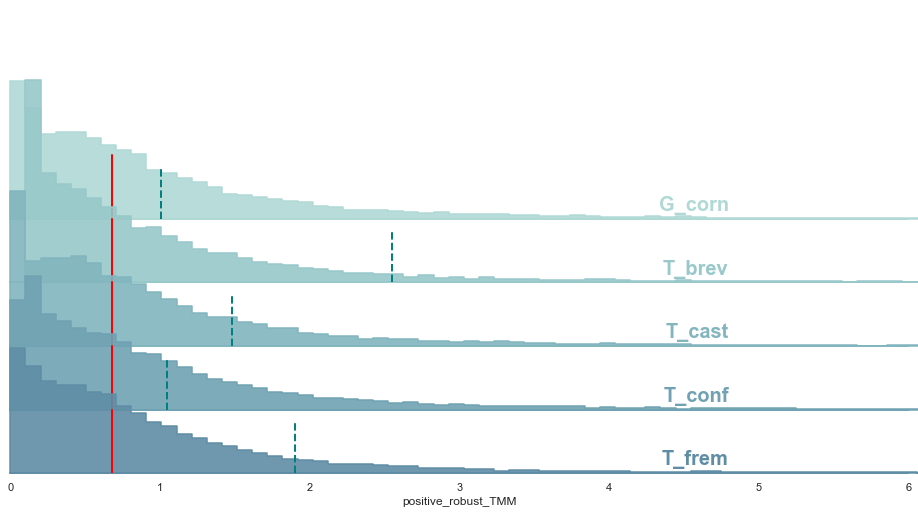

In [7]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.figure(figsize=(4,2))

# Initialize the FacetGrid object (controls for faded color and size of subplots)
pal = sns.cubehelix_palette(10, rot=-.25, light=.8)
g = sns.FacetGrid(scaled_df, row="species", hue="species", aspect=9, height=1.5, palette=pal)

# Draw the histograms (controls for style of bars) 
g.map(sns.histplot, "positive_robust_TMM", clip_on=False, fill=True, alpha=.9, lw=1.5, bins=np.linspace(0,10,100), element="step")


# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False);

# Label each subplot (control position on axes(h,v))
def label(x, color, label):
    ax = plt.gca()
    ax.text(.8, .11, label, fontweight="bold", fontsize="20", color=color, ha="right", va="top", transform=ax.transAxes)


g.map(label, "positive_robust_TMM")

# Set the amount of subplot overlap
g.figure.subplots_adjust(hspace=-.7);

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(xlim = (0,6))
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Draw median line on each distribution (note: ymax + hspace above = 1 to draw between axes)
median_position = scaled_df.groupby(['species'])['positive_robust_TMM'].median()
for ax, median_line in zip(g.axes.flat, median_position):
    ax.axvline(x=median_line, ymax = .3, color='red', linestyle='-', lw = 2);
    
mean_position = scaled_df.groupby(['species'])['positive_robust_TMM'].mean()
for ax, mean_line in zip(g.axes.flat, mean_position):
    ax.axvline(x=mean_line, ymax = .25, color='teal', linestyle='--', lw = 2);

Text(0.5, 0, '')

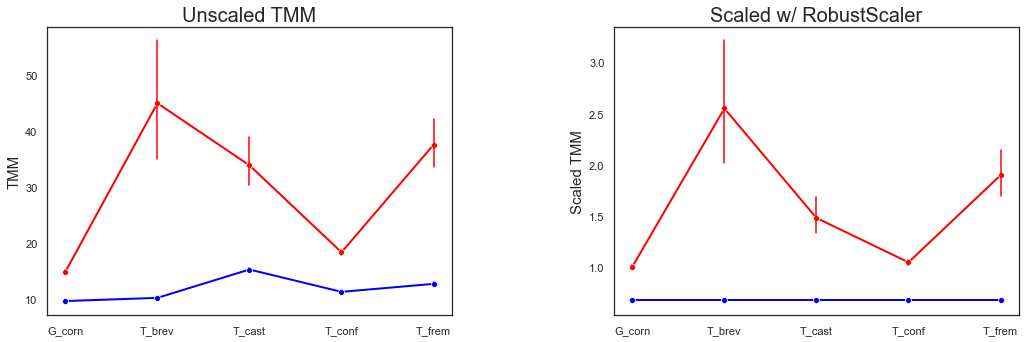

In [8]:
fig1, axes = plt.subplots(1, 2, figsize=(15,5))

plt.subplots_adjust(left=0.1,bottom=0.1, right=1, top=0.9, wspace=0.4, hspace=0.4)

sns.lineplot(ax=axes[0],data=scaled_df, x='species', y='Current_TMM', estimator = np.median, ci=95, err_style='bars', marker='o', color='blue', lw=2)
sns.lineplot(ax=axes[0],data=scaled_df, x='species', y='Current_TMM', estimator = 'mean', ci=95, err_style='bars', marker='o', color='red', lw=2)
axes[0].set_title ('Unscaled TMM', fontsize=20)
axes[0].set_ylabel('TMM',          fontsize=15)
axes[0].set_xlabel(None)

sns.lineplot(ax=axes[1],data=scaled_df, x='species', y='positive_robust_TMM', estimator = np.median, ci=95, err_style='bars', marker='o', color='blue', lw=2)
sns.lineplot(ax=axes[1],data=scaled_df, x='species', y='positive_robust_TMM', estimator = 'mean', ci=95, err_style='bars', marker='o', color='red', lw=2)
axes[1].set_title('Scaled w/ RobustScaler', fontsize=20)
axes[1].set_ylabel('Scaled TMM'  , fontsize=15)
axes[1].set_xlabel(None)

# Boxplot: Unscaled and Scaled Autosomes

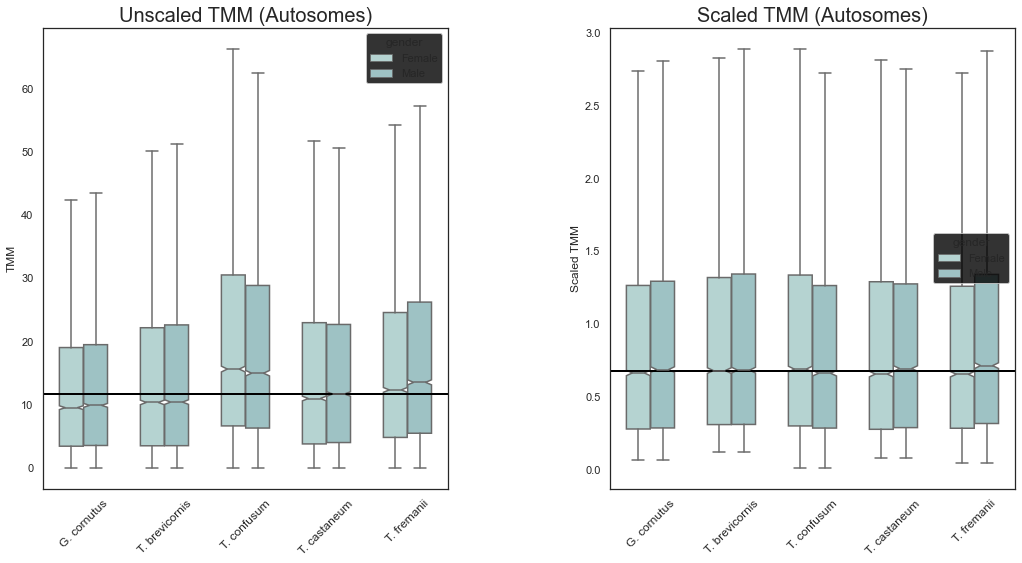

In [9]:
autosomes = scaled_df[scaled_df['chrom_name']=='Autosome']

fig1, axes = plt.subplots(1, 2, figsize=(15,8))

plt.subplots_adjust(left=0.1,bottom=0.1,right=1,top=0.9,wspace=0.4,hspace=0.4)
pal=sns.cubehelix_palette(10, rot=-.25, light=.8)
sns.boxplot(ax=axes[0],
            data = autosomes, 
            x='species', 
            y='Current_TMM',
            hue='gender',
            showfliers = False,
            notch= True, 
            width = .6, 
            palette = pal)\
            .axhline(autosomes['Current_TMM'].
                     median(),
                     linewidth=2, 
                     color='black')
axes[0].set_title ('Unscaled TMM (Autosomes)', fontsize=20)
axes[0].set_ylabel('TMM',          fontsize=12)
axes[0].set_xlabel(None)
axes[0].set_xticklabels(rotation=45, labels=['G. cornutus','T. brevicornis','T. confusum','T. castaneum','T. fremanii'], fontsize=12);

sns.boxplot(ax=axes[1],
            data = autosomes, 
            x='species', 
            y='positive_robust_TMM',
            hue='gender',
            showfliers = False,
            notch= True, width = .6, 
            palette = pal)\
            .axhline(autosomes['positive_robust_TMM'].
                     median(),
                     linewidth=2, 
                     color='black');
axes[1].set_title('Scaled TMM (Autosomes)', fontsize=20)
axes[1].set_ylabel('Scaled TMM'  , fontsize=12)
axes[1].set_xlabel(None)
axes[1].set_xticklabels(rotation=45, labels=['G. cornutus','T. brevicornis','T. confusum','T. castaneum','T. fremanii'],fontsize=12);

# Lineplot: Median Expression Across Chromosomes (unscaled & scaled)

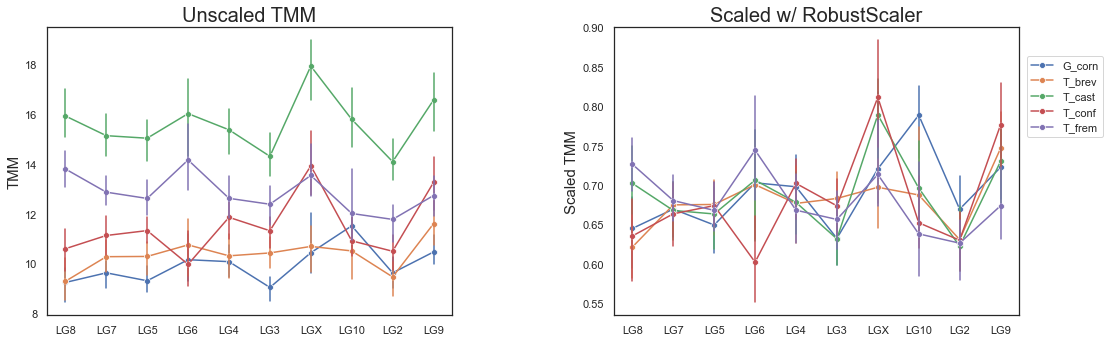

In [10]:
sns.set_style('white')
fig3, axes = plt.subplots(1, 2, figsize=(15,5))
plt.subplots_adjust(left=0.1,bottom=0.1,right=1,top=0.9,wspace=0.4,hspace=0.4)

sns.lineplot(ax=axes[0],data=scaled_df, x='chrom_num', y='Current_TMM', hue = 'species', estimator = np.median, ci=95, err_style='bars', marker='o', color='blue')
axes[0].set_title ('Unscaled TMM', fontsize=20)
axes[0].set_ylabel('TMM',          fontsize=15)
axes[0].set_xlabel(None)
axes[0].legend_.remove()

sns.lineplot(ax=axes[1],data=scaled_df, x='chrom_num', y='positive_robust_TMM', hue = 'species', estimator = np.median, ci=95, err_style='bars', marker='o', color='blue')
axes[1].set_title('Scaled w/ RobustScaler', fontsize=20)
axes[1].set_ylabel('Scaled TMM'  , fontsize=15)
axes[1].set_xlabel(None)
axes[1].legend(scaled_df['species'].unique(),bbox_to_anchor=(1.02, .9), loc='upper left', borderaxespad=0);

# Combine replicates and separate sexes

In [11]:
scaled_mean_df = pd.read_csv('scaled_df.csv')
scaled_mean_df = scaled_mean_df.groupby(['OrthoID', 'species', 'gender', 'chrom_num','chrom_name']).agg({'Current_TMM':['mean','sem'],'positive_robust_TMM':['mean','sem'],}).reset_index()
scaled_mean_df.columns = ["_".join(col_name).rstrip('_') for col_name in scaled_mean_df.columns.to_flat_index()] 

### OPTIONAL WRITE scaled_df after combining replicates checkpoint
scaled_mean_df.to_csv('scaled_mean_df.csv', index=False)
#display(scaled_mean_df.groupby('species')[['Current_TMM_mean','positive_robust_TMM_mean']].describe().transpose())

## Split Male and Female Data
Male_df   = scaled_mean_df.loc[(scaled_mean_df['gender']=='Male')]
Female_df = scaled_mean_df.loc[(scaled_mean_df['gender']=='Female')]

##Display
display(Male_df.groupby('species')[['Current_TMM_mean','positive_robust_TMM_mean']].describe().transpose())
display(Female_df.groupby('species')[['Current_TMM_mean','positive_robust_TMM_mean']].describe().transpose())

species                             G_corn       T_brev      T_cast  \
Current_TMM_mean         count 4072.000000  4072.000000 4072.000000   
                         mean    14.967320    47.507274   32.673211   
                         std     17.601061   724.619411  154.035920   
                         min      0.000000     0.000000    0.000000   
                         25%      3.758801     3.698831    6.331180   
                         50%     10.015493    10.602847   14.927624   
                         75%     19.819322    22.070438   28.588778   
                         max    288.988142 33661.707170 6896.306469   
positive_robust_TMM_mean count 4072.000000  4072.000000 4072.000000   
                         mean     1.007423     2.690903    1.429532   
                         std      1.113291    39.234803    6.692297   
                         min      0.060720     0.118603    0.010000   
                         25%      0.298469     0.318878    0.285067   
                         50%      0.694213     0.692698    0.658551   
                         75%      1.314318     1.313615    1.252078   
                         max     18.339605  1822.744997  299.629300   

species                             T_conf      T_frem  
Current_TMM_mean         count 4072.000000 4072.000000  
                         mean    18.122463   33.055612  
                         std     28.459722  180.883013  
                         min      0.000000    0.000000  
                         25%      4.114690    5.549295  
                         50%     11.690327   13.533052  
                         75%     22.590300   26.375835  
                         max   1059.268545 5759.175109  
positive_robust_TMM_mean count 4072.000000 4072.000000  
                         mean     1.033620    1.678013  
                         std      1.505529    8.939106  
                         min      0.074936    0.044429  
                         25%      0.292604    0.318671  
                         50%      0.693358    0.713222  
                         75%      1.269970    1.347903  
                         max     56.110609  284.658646

species                             G_corn       T_brev       T_cast  \
Current_TMM_mean         count 4072.000000  4072.000000  4072.000000   
                         mean    14.920878    42.349116    35.093717   
                         std     18.651768   658.147763   278.991082   
                         min      0.000000     0.000000     0.000000   
                         25%      3.553404     3.661238     7.419151   
                         50%      9.591323    10.282234    16.408375   
                         75%     18.987603    21.495671    30.880812   
                         max    259.921909 33436.918155 16169.552663   
positive_robust_TMM_mean count 4072.000000  4072.000000  4072.000000   
                         mean     1.004485     2.411612     1.534694   
                         std      1.179749    35.635670    12.121142   
                         min      0.060720     0.118603     0.010000   
                         25%      0.285477     0.316842     0.332335   
                         50%      0.667384     0.675339     0.722884   
                         75%      1.261711     1.282494     1.351658   
                         max     16.501127  1810.573707   702.517940   

species                             T_conf       T_frem  
Current_TMM_mean         count 4072.000000  4072.000000  
                         mean    18.709300    42.018278  
                         std     32.248700   335.688549  
                         min      0.000000     0.000000  
                         25%      3.850360     4.823678  
                         50%     10.998850    12.194677  
                         75%     22.815066    24.630491  
                         max   1296.551701 10425.943631  
positive_robust_TMM_mean count 4072.000000  4072.000000  
                         mean     1.064664     2.120941  
                         std      1.705967    16.589482  
                         min      0.074936     0.044429  
                         25%      0.278621     0.282812  
                         50%      0.656779     0.647081  
                         75%      1.281861     1.261650  
                         max     68.662970   515.286929

# Export for Ancestral Character Estimation (ACE) in R
- Pivot data 
- Remove sex specific genes from sex where they are not expressed

In [12]:
## Pivot Data to phytools format (Orthogroups in columns)
M_mean_df = Male_df.pivot_table  (index='species',columns='OrthoID', values = 'Current_TMM_mean').reindex(['G_corn', 'T_brev', 'T_conf', 'T_cast', 'T_frem']).reset_index()
M_sem_df  = Male_df.pivot_table  (index='species',columns='OrthoID', values = 'Current_TMM_mean') .reindex(['G_corn', 'T_brev', 'T_conf', 'T_cast', 'T_frem']).reset_index()
M_Robust_mean_df = Male_df.pivot_table  (index='species',columns='OrthoID', values = 'positive_robust_TMM_mean').reindex(['G_corn', 'T_brev', 'T_conf', 'T_cast', 'T_frem']).reset_index()
M_Robust_sem_df  = Male_df.pivot_table  (index='species',columns='OrthoID', values = 'positive_robust_TMM_sem') .reindex(['G_corn', 'T_brev', 'T_conf', 'T_cast', 'T_frem']).reset_index()

F_mean_df = Female_df.pivot_table(index='species',columns='OrthoID', values = 'Current_TMM_mean').reindex(['G_corn', 'T_brev', 'T_conf', 'T_cast', 'T_frem']).reset_index()
F_sem_df  = Female_df.pivot_table(index='species',columns='OrthoID', values = 'Current_TMM_mean') .reindex(['G_corn', 'T_brev', 'T_conf', 'T_cast', 'T_frem']).reset_index()
F_Robust_mean_df = Female_df.pivot_table(index='species',columns='OrthoID', values = 'positive_robust_TMM_mean').reindex(['G_corn', 'T_brev', 'T_conf', 'T_cast', 'T_frem']).reset_index()
F_Robust_sem_df  = Female_df.pivot_table(index='species',columns='OrthoID', values = 'positive_robust_TMM_sem') .reindex(['G_corn', 'T_brev', 'T_conf', 'T_cast', 'T_frem']).reset_index()


## Filter out sex-specific genes (i.e. TMM = 0)
M_zeros_list = (M_mean_df.loc[:, (M_mean_df==0).any()]).columns
F_zeros_list = (F_mean_df.loc[:, (F_mean_df==0).any()]).columns

M_mean_filtered_df = M_mean_df.drop(M_zeros_list, axis=1)
M_sem_filtered_df = M_sem_df.drop(M_zeros_list, axis=1)
M_Robust_mean_filtered_df = M_Robust_mean_df.drop(M_zeros_list, axis=1)
M_Robust_sem_filtered_df = M_Robust_sem_df.drop(M_zeros_list, axis=1)

F_mean_filtered_df = F_mean_df.drop(F_zeros_list, axis=1)
F_sem_filtered_df = F_sem_df.drop(F_zeros_list, axis=1)
F_Robust_mean_filtered_df = F_Robust_mean_df.drop(F_zeros_list, axis=1)
F_Robust_sem_filtered_df = F_Robust_sem_df.drop(F_zeros_list, axis=1)


## Write files for ACE
M_Robust_mean_filtered_df.to_csv ('./r_analysis/Data/mean/Male_Data_R_Robust_mean.csv',  index = False)
M_Robust_sem_filtered_df.to_csv  ('./r_analysis/Data/sem/Male_Data_R_Robust_sem.csv',    index = False)
M_mean_filtered_df.to_csv        ('./r_analysis/Data/mean/Male_Data_R_mean.csv',         index = False)
M_sem_filtered_df.to_csv         ('./r_analysis/Data/sem/Male_Data_R_sem.csv',           index = False)

F_Robust_mean_filtered_df.to_csv ('./r_analysis/Data/mean/Female_Data_R_Robust_mean.csv',index = False)
F_Robust_sem_filtered_df.to_csv  ('./r_analysis/Data/sem/Female_Data_R_Robust_sem.csv',  index = False)
F_mean_filtered_df.to_csv        ('./r_analysis/Data/mean/Female_Data_R_mean.csv',       index = False)
F_sem_filtered_df.to_csv         ('./r_analysis/Data/sem/Female_Data_R_sem.csv',         index = False)

In [13]:
print('Number of single copy orthogroups w/ TMM=0 in Males = ' + str(len(M_mean_df.columns)-len(M_mean_filtered_df.columns)))
print('Number of single copy orthogroups w/ TMM=0 in Females = ' + str(len(F_mean_df.columns)-len(F_mean_filtered_df.columns)))

Number of single copy orthogroups w/ TMM=0 in Males = 165
Number of single copy orthogroups w/ TMM=0 in Females = 48


# Read results from R into Pandas df
* Scaled

In [14]:
## Robust Scaler

# Combine Male and Female outputs from phytools in wide format
M_ACE_Robust_df = pd.read_csv('./r_analysis/Results/Male_ACE_R_Robust_mean.csv'  ).set_index('OrthoID')   
M_ACE_Robust_df.insert(0,'gender','Male')
F_ACE_Robust_df = pd.read_csv('./r_analysis/Results/Female_ACE_R_Robust_mean.csv').set_index('OrthoID')    
F_ACE_Robust_df.insert(0,'gender','Female')
Combined_ACE_Robust__wide_df = pd.concat([M_ACE_Robust_df,F_ACE_Robust_df])

# Convert to long format, matching ancestral nodes with correct species
species_df   = Combined_ACE_Robust__wide_df.iloc[:,0:6].reset_index().set_index(['OrthoID','gender']).stack().rename_axis(['OrthoID','gender','species']).rename('Robust_TMM').reset_index()
ancestors_df = Combined_ACE_Robust__wide_df.iloc[:,[0]+list(range(6, 10))+[9]].reset_index().set_index(['OrthoID','gender']).stack().rename_axis(['OrthoID','gender','ancestral_node']).rename('Robust_ACE').reset_index()
Combined_ACE_Robust_df= pd.concat([species_df , ancestors_df.iloc[:,2:4]], axis=1)

# Get chrom_num and chrom_name from scaled_df
Combined_ACE_Robust_df = pd.merge(scaled_mean_df.iloc[:,0:5], Combined_ACE_Robust_df, on=['OrthoID','species','gender'], how='right')
Combined_ACE_Robust_df.groupby(['species','gender']).describe().transpose()

species               G_corn                  T_brev                  T_cast  \
gender                Female        Male      Female        Male      Female   
Robust_TMM count 4024.000000 3907.000000 4024.000000 3907.000000 4024.000000   
           mean     1.012595    1.039629    2.438378    1.092074    1.544243   
           std      1.178354    1.118456   35.846778    1.295386   12.191283   
           min      0.062476    0.062216    0.118886    0.120398    0.010727   
           25%      0.297610    0.338604    0.328784    0.354616    0.338934   
           50%      0.673052    0.718116    0.687640    0.713002    0.727523   
           75%      1.266385    1.347560    1.298139    1.315846    1.353952   
           max     16.501127   18.339605 1810.573707   18.140431  702.517940   
Robust_ACE count 4024.000000 3907.000000 4024.000000 3907.000000 4024.000000   
           mean     1.530456    1.168446    1.681134    1.205927    1.770875   
           std      9.024163    1.783633   11.604755    2.180983   10.635165   
           min      0.074005    0.074851    0.076636    0.077514    0.032882   
           25%      0.400948    0.437244    0.395840    0.434277    0.354793   
           50%      0.779644    0.805498    0.783456    0.807126    0.730682   
           75%      1.375897    1.408133    1.398377    1.397887    1.341181   
           max    438.399068   54.597022  564.500672   70.409903  381.424818   

species                           T_conf                  T_frem              
gender                  Male      Female        Male      Female        Male  
Robust_TMM count 3907.000000 4024.000000 3907.000000 4024.000000 3907.000000  
           mean     1.471145    1.057720    1.050791    2.046569    1.685074  
           std      6.745365    1.341331    1.231243   16.351422    8.753669  
           min      0.010669    0.075891    0.076231    0.045203    0.044998  
           25%      0.329499    0.288127    0.335850    0.289208    0.356671  
           50%      0.698597    0.663439    0.723833    0.652949    0.746601  
           75%      1.292629    1.292721    1.306618    1.264058    1.374694  
           max    299.629300   19.002637   21.786267  515.286929  284.658646  
Robust_ACE count 3907.000000 4024.000000 3907.000000 4024.000000 3907.000000  
           mean     1.540231    1.586586    1.255664    1.770875    1.540231  
           std      6.748561    7.947385    2.856630   10.635165    6.748561  
           min      0.034461    0.067165    0.068063    0.032882    0.034461  
           25%      0.378128    0.387517    0.425978    0.354793    0.378128  
           50%      0.747700    0.772927    0.800717    0.730682    0.747700  
           75%      1.355347    1.403102    1.395068    1.341181    1.355347  
           max    237.699021  336.947486   96.715144  381.424818  237.699021

* Unscaled

In [15]:
## Unscaled

# Combine Male and Female outputs from phytools in wide format
M_ACE_df   = pd.read_csv('./r_analysis/Results/Male_ACE_R_mean.csv'  ).set_index('OrthoID')   
M_ACE_df.insert(0,'gender','Male')
F_ACE_df   = pd.read_csv('./r_analysis/Results/Female_ACE_R_mean.csv').set_index('OrthoID')    
F_ACE_df.insert(0,'gender','Female')
Combined_ACE__wide_df = pd.concat([M_ACE_df,F_ACE_df])

# Convert to long format, matching ancestral nodes with correct species
species_df   = Combined_ACE__wide_df.iloc[:,0:6].reset_index().set_index(['OrthoID','gender']).stack().rename_axis(['OrthoID','gender','species']).rename('TMM').reset_index()
ancestors_df = Combined_ACE__wide_df.iloc[:,[0]+list(range(6, 10))+[9]].reset_index().set_index(['OrthoID','gender']).stack().rename_axis(['OrthoID','gender','ancestral_node']).rename('ACE').reset_index()
Combined_ACE_df= pd.concat([species_df , ancestors_df.iloc[:,2:4]], axis=1)

# Get chrom_num and chrom_name from scaled_df
Combined_ACE_df = pd.merge(scaled_mean_df.iloc[:,0:5], Combined_ACE_df, on=['OrthoID','species','gender'], how='right')
Combined_ACE_df

,OrthoID,species,gender,chrom_num,chrom_name,TMM,ancestral_node,ACE
0,OG0009837,G_corn,Male,LG8,Autosome,0.270534,A_MRCA,0.331137
1,OG0009837,T_brev,Male,LG8,Autosome,0.444479,B_Tbrev_anc,0.348771
2,OG0009837,T_conf,Male,LG3,Autosome,0.452259,C_Tconf_anc,0.335988
3,OG0009837,T_cast,Male,LG2,"LG2,Neo-X",0.044854,D_Tfree-Tcast_anc,0.212608
4,OG0009837,T_frem,Male,LG2,"LG2,Neo-X",0.347515,D_Tfree-Tcast_anc,0.212608
...,...,...,...,...,...,...,...,...
39650,OG0015235,G_corn,Female,LG5,Autosome,5.485848,A_MRCA,5.207161
39651,OG0015235,T_brev,Female,LG5,Autosome,4.027380,B_Tbrev_anc,5.126074
39652,OG0015235,T_conf,Female,LG5,Autosome,5.505339,C_Tconf_anc,5.344492
39653,OG0015235,T_cast,Female,LG5,Autosome,6.673982,D_Tfree-Tcast_anc,5.756607


# Compute current:ancestral ratios (normal and log2)

In [16]:
Combined_ACE_df['TMM_log2(Current:Ancestral)'] = np.log2(Combined_ACE_df['TMM']/Combined_ACE_df['ACE'])
Combined_ACE_df['TMM(Current:Ancestral)'] = Combined_ACE_df['TMM']/Combined_ACE_df['ACE']

Combined_ACE_Robust_df['Robust_log2(Current:Ancestral)'] = np.log2(Combined_ACE_Robust_df['Robust_TMM']/Combined_ACE_Robust_df['Robust_ACE'])
Combined_ACE_Robust_df['Robust(Current:Ancestral)'] = Combined_ACE_Robust_df['Robust_TMM']/Combined_ACE_Robust_df['Robust_ACE']

LG2_NeoX_count = Combined_ACE_df.loc[Combined_ACE_df['chrom_name']=='LG2,Neo-X'].groupby(['species','gender'])['TMM_log2(Current:Ancestral)'].size().tolist()

#Combined_ACE_df.groupby(['species','gender'])['TMM_log2(Current:Ancestral)'].describe().transpose()
display(Combined_ACE_Robust_df)
Combined_ACE_Robust_df.loc[Combined_ACE_Robust_df['species']=='T_cast'].to_csv('current_ancestral.csv', index=False)

,OrthoID,species,gender,chrom_num,chrom_name,Robust_TMM,ancestral_node,Robust_ACE,Robust_log2(Current:Ancestral),Robust(Current:Ancestral)
0,OG0009837,G_corn,Male,LG8,Autosome,0.077832,A_MRCA,0.088741,-0.189245,0.877065
1,OG0009837,T_brev,Male,LG8,Autosome,0.142669,B_Tbrev_anc,0.091915,0.634301,1.552186
2,OG0009837,T_conf,Male,LG3,Autosome,0.098860,C_Tconf_anc,0.081488,0.278812,1.213195
3,OG0009837,T_cast,Male,LG2,"LG2,Neo-X",0.011949,D_Tfree-Tcast_anc,0.042028,-1.814503,0.284302
4,OG0009837,T_frem,Male,LG2,"LG2,Neo-X",0.061603,D_Tfree-Tcast_anc,0.042028,0.551636,1.465747
...,...,...,...,...,...,...,...,...,...,...
39650,OG0015235,G_corn,Female,LG5,Autosome,0.407707,A_MRCA,0.358734,0.184617,1.136515
39651,OG0015235,T_brev,Female,LG5,Autosome,0.336667,B_Tbrev_anc,0.344485,-0.033119,0.977305
39652,OG0015235,T_conf,Female,LG5,Autosome,0.366170,C_Tconf_anc,0.337963,0.115647,1.083461
39653,OG0015235,T_cast,Female,LG5,Autosome,0.299960,D_Tfree-Tcast_anc,0.299589,0.001785,1.001238


# Figure 1: NeoX/LG2 males and females in each species (boxplot)


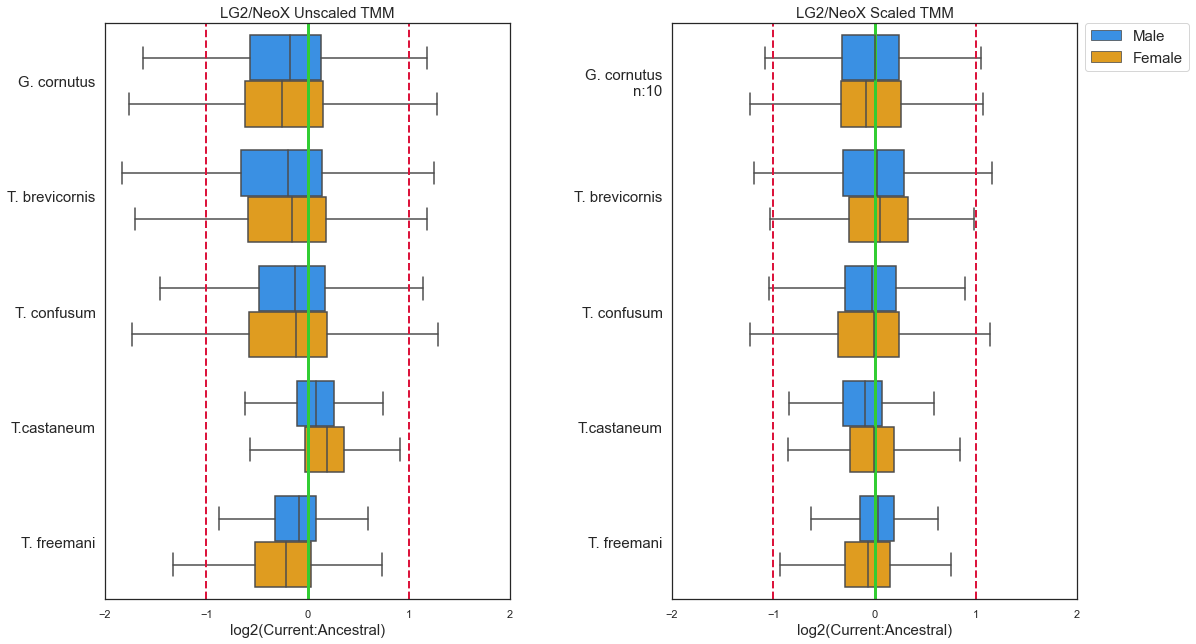

In [17]:
LG2NeoX_Robust = Combined_ACE_Robust_df[Combined_ACE_Robust_df['chrom_name']=='LG2,Neo-X']
LG2NeoX = Combined_ACE_df[Combined_ACE_df['chrom_name']=='LG2,Neo-X']

fig6, axs = plt.subplots(1, 2, figsize=(15,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

ax=sns.boxplot(ax=axs[0], data=LG2NeoX, y='species', order = ('G_corn','T_brev','T_conf','T_cast','T_frem'),x = 'TMM_log2(Current:Ancestral)', hue='gender', showfliers = False, palette=['dodgerblue', 'orange'])
axs[0].set_xlim(-2,2)
axs[0].set_xlabel('log2(Current:Ancestral)', size=15)
axs[0].set_ylabel(None) 
axs[0].axvline (0, ls='-' , color='limegreen', lw = 3)
[axs[0].axvline(x, ls='--', color='crimson'  , lw = 2) for x in [-1,1]]
axs[0].set_title('LG2/NeoX Unscaled TMM', size=15)
axs[0].set(xticks=(range(-2,3,1)))
axs[0].set_yticklabels(['G. cornutus','T. brevicornis','T. confusum','T.castaneum','T. freemani'], size=15)
axs[0].legend_.remove()

ax=sns.boxplot(ax=axs[1], data=LG2NeoX_Robust, y='species', order = ('G_corn','T_brev','T_conf','T_cast','T_frem'),x = 'Robust_log2(Current:Ancestral)', hue='gender', showfliers = False, palette=['dodgerblue', 'orange'])
axs[1].set_xlim(-2,2)
axs[1].set_xlabel('log2(Current:Ancestral)', size=15)
axs[1].set_ylabel(None) 
axs[1].axvline (0, ls='-' , color='limegreen', lw = 3)
[axs[1].axvline(x, ls='--', color='crimson'  , lw = 2) for x in [-1,1]]
axs[1].set_title('LG2/NeoX Scaled TMM', size=15)
axs[1].set(xticks=(range(-2,3,1)))
axs[1].set_yticklabels(['G. cornutus\nn:'+'10' ,'T. brevicornis','T. confusum','T.castaneum','T. freemani'], size=15)
axs[1].legend_.remove()

axs[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', prop={'size': 15}, borderaxespad=0);

def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        #print (text)
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])
#add_median_labels(axs[0])
#add_median_labels(axs[1])

# Figure 2: Autosomes, NeoX/LG2, X in each species; males and females on separate graphs (boxplots)
* First is for Robust scaler

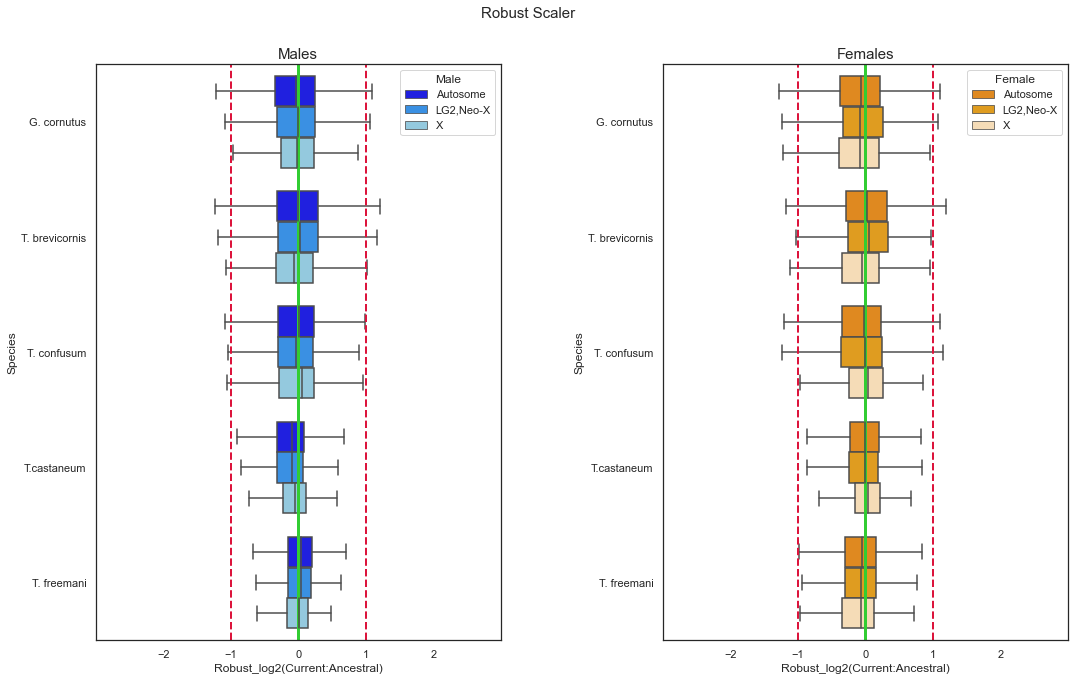

In [18]:
fig2_ratios = 'Robust_log2(Current:Ancestral)'

fig2, axs = plt.subplots(1, 2, figsize=(15,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.suptitle('Robust Scaler',fontsize=15)
sns.boxplot(ax=axs[0], data=Combined_ACE_Robust_df[Combined_ACE_Robust_df['gender']=='Male'], y='species', order = ('G_corn','T_brev','T_conf','T_cast','T_frem'), x = fig2_ratios, hue='chrom_name', showfliers=False, palette=['blue','dodgerblue','skyblue'])
axs[0].set_xlim(-3,3)
axs[0].set_ylabel('Species', size=12) 
axs[0].set(yticklabels=['G. cornutus','T. brevicornis','T. confusum','T.castaneum','T. freemani'])
axs[0].axvline (0, ls='-' , color='limegreen', lw = 3)
[axs[0].axvline(x, ls='--', color='crimson'  , lw = 2) for x in [-1,1]]
axs[0].set_title('Males', size=15) 
axs[0].set(xticks=(range(-2,3,1)))
axs[0].legend(title='Male')

sns.boxplot(ax=axs[1], data=Combined_ACE_Robust_df[Combined_ACE_Robust_df['gender']=='Female'], y='species', order = ('G_corn','T_brev','T_conf','T_cast','T_frem'),x=fig2_ratios, hue='chrom_name', showfliers=False, palette=['darkorange','orange','navajowhite'])
axs[1].set_xlim(-3,3)
axs[1].set_ylabel('Species', size=12) 
axs[1].set(yticklabels=['G. cornutus','T. brevicornis','T. confusum','T.castaneum','T. freemani'])
axs[1].axvline (0, ls='-' , color='limegreen', lw = 3)
[axs[1].axvline(x, ls='--', color='crimson'  , lw = 2) for x in [-1,1]]
axs[1].set_title('Females', size=15) 
axs[1].set(xticks=(range(-2,3,1)))
axs[1].legend(title='Female');

* Second is for Unscaled TMM

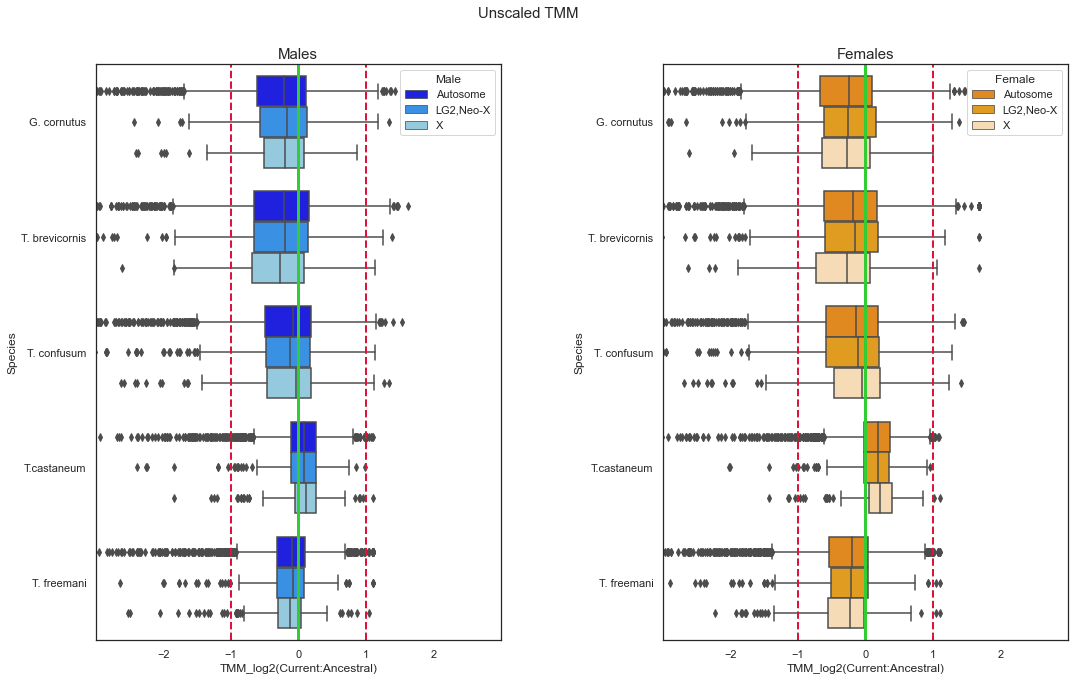

In [19]:
fig2b_ratios = 'TMM_log2(Current:Ancestral)'

fig2b, axs = plt.subplots(1, 2, figsize=(15,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.suptitle('Unscaled TMM',fontsize=15)

sns.boxplot(ax=axs[0], data=Combined_ACE_df[Combined_ACE_df['gender']=='Male'], y='species', order = ('G_corn','T_brev','T_conf','T_cast','T_frem'), x = fig2b_ratios, hue='chrom_name', palette=['blue','dodgerblue','skyblue'])
axs[0].set_xlim(-3,3)
axs[0].set_ylabel('Species', size=12) 
axs[0].set(yticklabels=['G. cornutus','T. brevicornis','T. confusum','T.castaneum','T. freemani'])
axs[0].axvline (0, ls='-' , color='limegreen', lw = 3)
[axs[0].axvline(x, ls='--', color='crimson'  , lw = 2) for x in [-1,1]]
axs[0].set_title('Males', size=15) 
axs[0].set(xticks=(range(-2,3,1)))
axs[0].legend(title='Male')

sns.boxplot(ax=axs[1], data=Combined_ACE_df[Combined_ACE_df['gender']=='Female'], y='species', order = ('G_corn','T_brev','T_conf','T_cast','T_frem'),x=fig2b_ratios, hue='chrom_name', palette=['darkorange','orange','navajowhite'])
axs[1].set_xlim(-3,3)
axs[1].set_ylabel('Species', size=12) 
axs[1].set(yticklabels=['G. cornutus','T. brevicornis','T. confusum','T.castaneum','T. freemani'])
axs[1].axvline (0, ls='-' , color='limegreen', lw = 3)
[axs[1].axvline(x, ls='--', color='crimson'  , lw = 2) for x in [-1,1]]
axs[1].set_title('Females', size=15) 
axs[1].set(xticks=(range(-2,3,1)))
axs[1].legend(title='Female');

# Compute Log2(NeoX:Autosome)

In [20]:
data_mean_df = data.groupby(['OrthoID', 'species', 'gender', 'chrom_num','chrom_name']).agg({'Current_TMM':['mean']}).reset_index()
data_mean_df.columns = ["_".join(col_name).rstrip('_') for col_name in data_mean_df.columns.to_flat_index()] 

### OPTIONAL WRITE scaled_df after combining replicates checkpoint
data_mean_df.to_csv('data_mean_df.csv', index=False)
#display(data_mean_df.groupby('species')['Current_TMM_mean'].describe().transpose())

agg_data_df = data_mean_df.groupby(['species','gender','chrom_name']).agg('mean').reset_index()
agg_data_pivot = agg_data_df.pivot_table(index=['species','gender'], columns=['chrom_name'], values = 'Current_TMM_mean')
agg_data_pivot['log2X_Autosome'] = agg_data_pivot['X']/agg_data_pivot['Autosome']
display(agg_data_pivot)
    
## Split Male and Female Data
#Male_all_df   = data_mean_df.loc[(scaled_mean_df['gender']=='Male')]
#Female_all_df = data_mean_df.loc[(scaled_mean_df['gender']=='Female')]

##Display
#display(Male_all_df.groupby('species')[['Current_TMM_mean']].describe().transpose())
#display(Female_all_df.groupby('species')[['Current_TMM_mean']].describe().transpose())

chrom_name      Autosome  LG2,Neo-X         X  log2X_Autosome
species gender                                               
G_corn  Female 27.271409  23.595675 25.474199        0.934099
        Male   25.601636  22.262723 23.340988        0.911699
T_brev  Female 40.771438  28.784556 22.831449        0.559986
        Male   44.301296  31.353762 24.703663        0.557628
T_cast  Female 49.299367  48.395465 40.872701        0.829072
        Male   48.958744  51.102194 40.960633        0.836636
T_conf  Female 34.473920  39.342956 28.366888        0.822851
        Male   31.484837  33.749569 26.375217        0.837712
T_frem  Female 37.981941  34.204722 58.969465        1.552566
        Male   37.756796  36.249590 26.584742        0.704105

# Import Pagel's Lambda and K  from phylosig

In [21]:
## Robust Scaler

## Import Pagel's Lambda Results
M_PAGEL_Robust_df = pd.read_csv('./r_analysis/Results/Male_PAGEL_R_Robust_mean.csv'  ).set_index('OrthoID')   
M_PAGEL_Robust_df.insert(0,'gender','Male')
F_PAGEL_Robust_df = pd.read_csv('./r_analysis/Results/Female_PAGEL_R_Robust_mean.csv').set_index('OrthoID')    
F_PAGEL_Robust_df.insert(0,'gender','Female')

CombinePAGEL_Robust_df = pd.concat([M_PAGEL_Robust_df,F_PAGEL_Robust_df])

## Import Blomberg's K Results
M_BLOM_K_Robust_df = pd.read_csv('./r_analysis/Results/Male_BLOM_K_R_Robust_mean.csv'  ).set_index('OrthoID')   
M_BLOM_K_Robust_df.insert(0,'gender','Male')
F_BLOM_K_Robust_df = pd.read_csv('./r_analysis/Results/Female_BLOM_K_R_Robust_mean.csv').set_index('OrthoID')    
F_BLOM_K_Robust_df.insert(0,'gender','Female')

CombineBLOM_K_Robust_df = pd.concat([M_BLOM_K_Robust_df,F_BLOM_K_Robust_df])

print(CombinePAGEL_Robust_df.describe())
print(CombineBLOM_K_Robust_df.describe())



FileNotFoundError: [Errno 2] No such file or directory: './r_analysis/Results/Male_PAGEL_R_Robust_mean.csv'

In [ ]:
CombinePAGEL_Robust_df.hist(column='Lambda', by = 'gender', figsize=(10, 5))
CombinePAGEL_Robust_df.hist(column='P', by = 'gender', figsize=(10, 5))

In [ ]:
sns.violinplot(data=CombinePAGEL_Robust_df, x='Lambda', y = 'gender')

In [ ]:
CombineBLOM_K_Robust_df.hist(column='K', by = 'gender', figsize=(10, 5))
CombineBLOM_K_Robust_df.hist(column='P', by = 'gender', figsize=(10, 5))

In [ ]:
ax1=sns.violinplot(data=CombineBLOM_K_Robust_df, x='K', y = 'gender')
ax2=sns.violinplot(data=CombineBLOM_K_Robust_df, x='P', y = 'gender')
for violin, alpha in zip(ax2.collections[::2], [1,1,0.5,0.5]):
    violin.set_alpha(alpha)